In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 
import random

import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, Input, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16

from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
# Create an instance of the ImageDataGenerator with specified augmentations
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [5]:
# Create tensorflow dataset to visualize
train_dataset = datagen.flow_from_directory(
    directory = "/kaggle/input/intel-image-classification/seg_train/seg_train",
    class_mode = "sparse",
    batch_size = 32,
    target_size = (256,256),
    shuffle = True
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    directory = "/kaggle/input/intel-image-classification/seg_test/seg_test",
    labels = "inferred",
    batch_size = 32,
    image_size = (256,256),
    shuffle = False
).prefetch(tf.data.AUTOTUNE)

Found 14034 images belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [6]:
# Label to natural scence
scene_dict = {
    0 : "buildings",
    1 : "forest",
    2 : "glacier",
    3 : "mountain",
    4 : "sea",
    5 : "street"
}

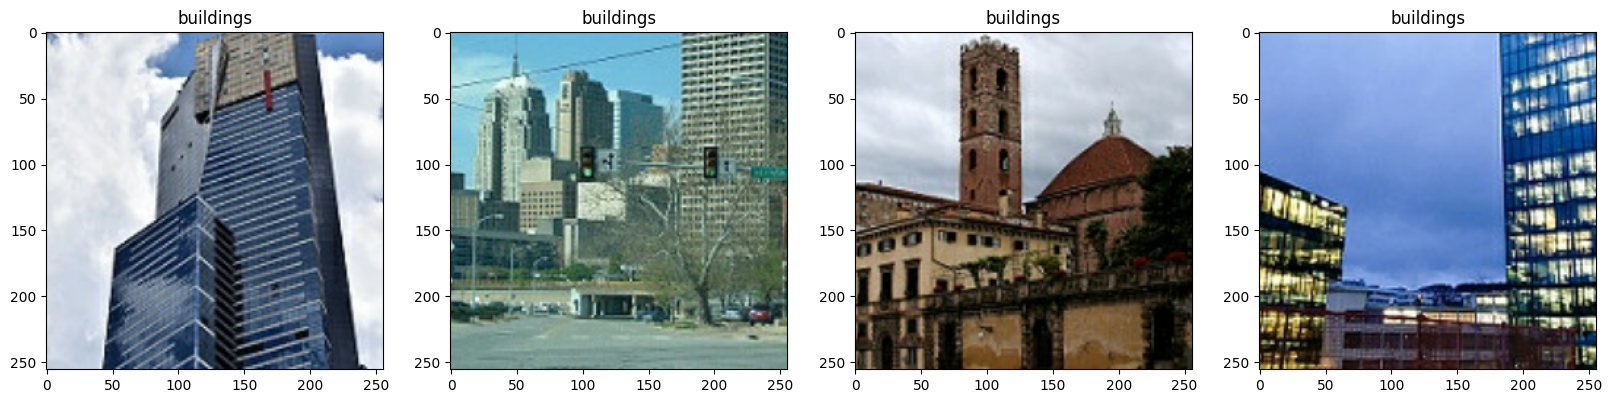

In [7]:
# View a batch
data_iter = validation_dataset.as_numpy_iterator()
batch = data_iter.next()
# Visualize 4 images in a batch
fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize = (20,20))
for i, img in enumerate(batch[0][:4]):
  axes[i].imshow(img.astype(int))
  axes[i].set_title(scene_dict[batch[1][i]])

In [8]:
# Data Preprocessing
# Scale the data by 255
validation_dataset = validation_dataset.map(lambda x, y: (x/255, y))

In [9]:
# Build the CNN
def build_model():
  input = Input(shape = (256,256,3)) # Input image

  x = Conv2D(8, kernel_size = 3, activation = "relu") (input)
  x = Conv2D(16, kernel_size = 3, activation = "relu") (x)
  x = MaxPool2D(pool_size = 2) (x)
  x = Dropout(0.3) (x)
  x = BatchNormalization() (x)
  x = Conv2D(32, kernel_size = 3, activation = "relu") (x)
  x = MaxPool2D(pool_size = 2) (x)
  x = Dropout(0.3) (x)
  x = Conv2D(64, kernel_size = 3, activation = "relu") (x)
  x = MaxPool2D(pool_size = 2) (x)

  x = Flatten() (x)
  x = Dense(64, activation = "relu") (x)
  output = Dense(6, activation = "softmax") (x)

  model = Model(inputs = input, outputs = output, name = "cnn_model_1")
  return model

In [10]:
model = build_model()

In [11]:
model.summary()

Model: "cnn_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 8)       224       
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 16)      1168      
                                                                 
 max_pooling2d (MaxPooling2  (None, 126, 126, 16)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 126, 126, 16)      0         
                                                                 
 batch_normalization (Batch  (None, 126, 126, 16)      64        
 Normalization)                                        

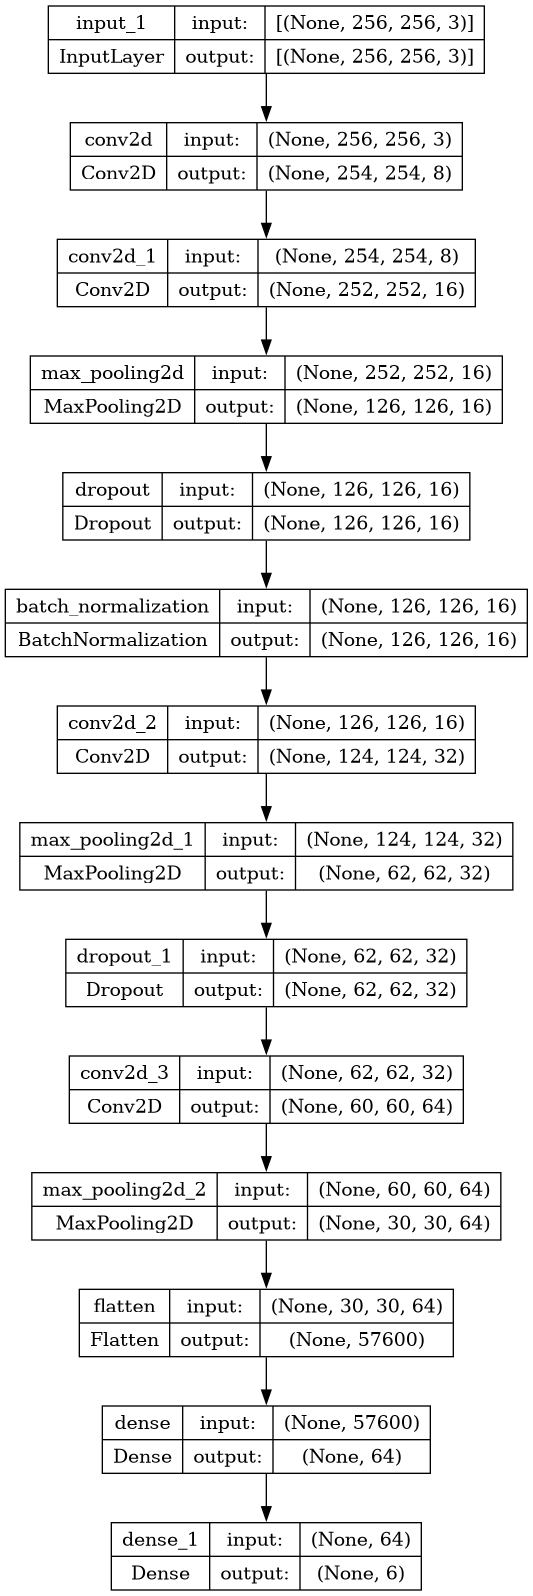

In [12]:
tf.keras.utils.plot_model(model, show_shapes = True)

In [13]:
# Use a VGG16 model
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(256,256, 3))
# for layer in vgg.layers:
#     layer.trainable = False
    
def build_vgg_model():
    input_image = Input(shape = (256,256,3)) # Input image
    x = vgg(input_image, training = False)
    x = GlobalAveragePooling2D() (x)
    x = Dense(256, activation = "relu") (x)
    x = BatchNormalization() (x)
    x = Dropout(0.5) (x)
    output = Dense(6, activation = "softmax") (x)
    
    model = Model(inputs = input_image, outputs = output, name = "cnn_model_1")
    return model
    

58889256/58889256 [==============================] - 0s 0us/step


In [14]:
model = build_vgg_model()
# vgg.trainable = True

In [15]:
# optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

In [16]:
# Complile the model
model.compile(optimizer = optimizer, loss = loss_fn, metrics = ["accuracy"])

In [17]:
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss", 
    patience = 5,
    restore_best_weights = True, 
    verbose = True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = "models/best_vgg_model.h5",
    monitor = "val_loss",
    verbose = 1,
    save_best_only = True,
    save_freq='epoch',
    mode = "min"
)
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = "val_loss",
    verbose = 1,
    factor = 0.2,
    patience = 3,
    min_lr = 1e-7)

In [18]:
history = model.fit(train_dataset, epochs = 100, validation_data = validation_dataset, callbacks = [es_callback, model_checkpoint, lr_reduce])

Epoch 1/100
439/439 [==============================] - ETA: 0s - loss: 0.6440 - accuracy: 0.7683
Epoch 1: val_loss improved from inf to 0.45048, saving model to models/best_vgg_model.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


439/439 [==============================] - 370s 790ms/step - loss: 0.6440 - accuracy: 0.7683 - val_loss: 0.4505 - val_accuracy: 0.8450 - lr: 1.0000e-04
Epoch 2/100
439/439 [==============================] - ETA: 0s - loss: 0.4249 - accuracy: 0.8531
Epoch 2: val_loss improved from 0.45048 to 0.34048, saving model to models/best_vgg_model.h5
439/439 [==============================] - 272s 618ms/step - loss: 0.4249 - accuracy: 0.8531 - val_loss: 0.3405 - val_accuracy: 0.8690 - lr: 1.0000e-04
Epoch 3/100
439/439 [==============================] - ETA: 0s - loss: 0.3625 - accuracy: 0.8766
Epoch 3: val_loss did not improve from 0.34048
439/439 [==============================] - 271s 617ms/step - loss: 0.3625 - accuracy: 0.8766 - val_loss: 0.4204 - val_accuracy: 0.8637 - lr: 1.0000e-04
Epoch 4/100
439/439 [==============================] - ETA: 0s - loss: 0.3279 - accuracy: 0.8871
Epoch 4: val_loss improved from 0.34048 to 0.32724, saving model to models/best_vgg_model.h5
439/439 [===========

## Model Performance

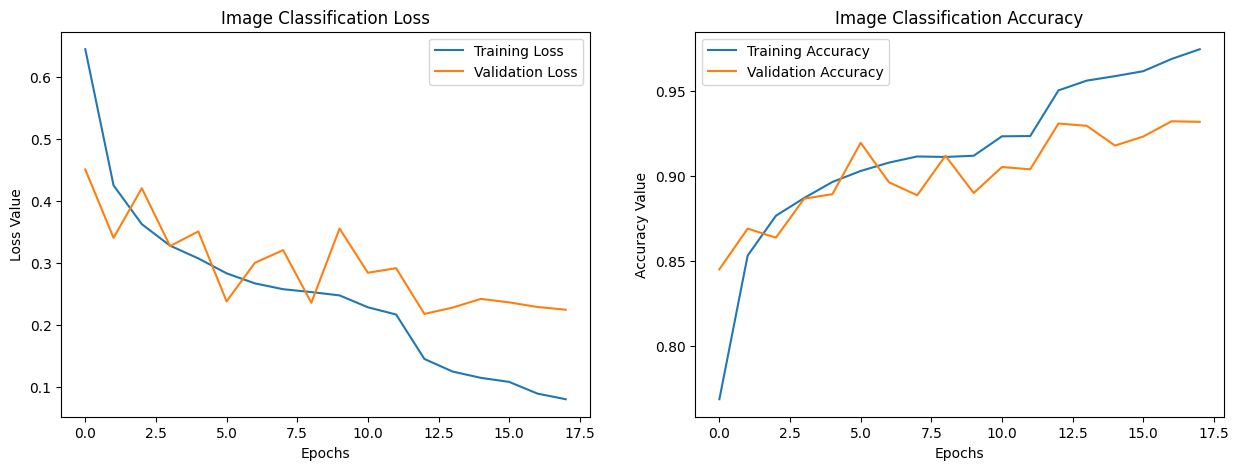

In [19]:
# Plot loss and accuracy
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))
axes[0].plot(history.history["loss"], label = "Training Loss")
axes[0].plot(history.history["val_loss"], label = "Validation Loss")
axes[0].set_title("Image Classification Loss")
axes[0].set_ylabel("Loss Value")
axes[0].set_xlabel("Epochs")
axes[0].legend()

axes[1].plot(history.history["accuracy"], label = "Training Accuracy")
axes[1].plot(history.history["val_accuracy"], label = "Validation Accuracy")
axes[1].set_title("Image Classification Accuracy")
axes[1].set_ylabel("Accuracy Value")
axes[1].set_xlabel("Epochs")
axes[1].legend()

plt.show()

94/94 [==============================] - 15s 159ms/step


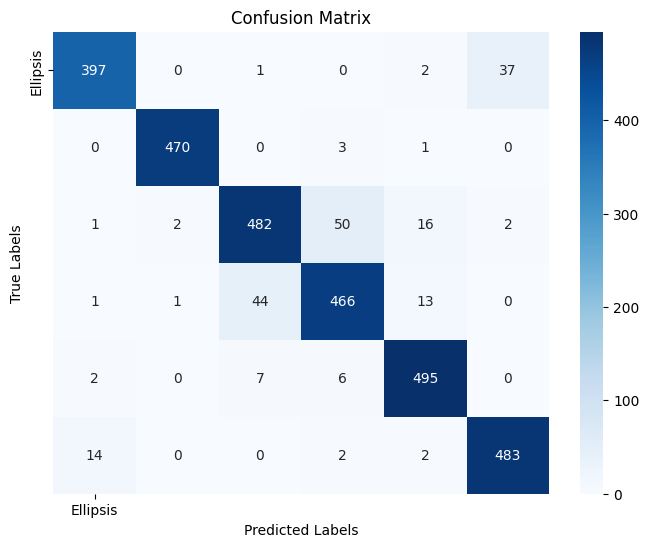

In [21]:
# Confusion Matrix

# Extract true labels from the validation dataset
true_labels = []
for features, labels in validation_dataset:
    true_labels.extend(labels)

# Make predictions
y_pred_prob = model.predict(validation_dataset)
y_pred = np.argmax(y_pred_prob, axis=1)

conf_matrix = confusion_matrix(true_labels, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[...], yticklabels=[...])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

The model is having the most difficulty distinguishing between glaciers and mountains

In [22]:
# Final Accuracy
accuracy = model.evaluate(validation_dataset)[1]
print(accuracy)

94/94 [==============================] - 15s 162ms/step - loss: 0.2180 - accuracy: 0.9310
0.9309999942779541


## Testing Model on Sample Images

In [23]:
def select_random_images(directory_path, num_images=10):
    # Get a list of all file paths in the directory
    all_files = [os.path.join(directory_path, file) for file in os.listdir(directory_path)]

    # Select a random subset of file paths
    random_files = random.sample(all_files, min(num_images, len(all_files)))

    return random_files

In [24]:
def load_images(image_paths):
    images = []
    for path in image_paths:
        # Read the image using OpenCV
        image = cv2.imread(path)
        
        # Convert BGR to RGB 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (256, 256))
        
        images.append(image)
    
    return np.array(images)

In [26]:
# Plotting all images with predicted labels
def plot_images_predictions(images, image_predictions, num_cols = 3):
    num_images = len(images)
    num_rows = (num_images//3) + (num_images % 3)
    
    fig, axes = plt.subplots(nrows = num_rows, ncols = num_cols, figsize = (15, 5 * num_rows))
    
    for i in range(num_rows):
        for j in range(num_cols):
            index = i * num_cols + j
            if index < num_images:
                axes[i, j].imshow(images[index])
                axes[i, j].set_title(f"Image Prediction: {scene_dict[image_predictions[index]]}")
                axes[i, j].axis('off')
    plt.show()

In [27]:
# Combine all into one function
def predict_images(num_images = 10):
    directory_path = '/kaggle/input/intel-image-classification/seg_pred/seg_pred'

    random_image_paths = select_random_images(directory_path, num_images=num_images)
    loaded_images = load_images(random_image_paths)
    
    # Get image predictions
    image_predictions = model.predict(loaded_images)
    image_predictions = np.argmax(image_predictions, axis = 1)
    
    # Plot predictions and images
    plot_images_predictions(loaded_images, image_predictions)

1/1 [==============================] - 4s 4s/step


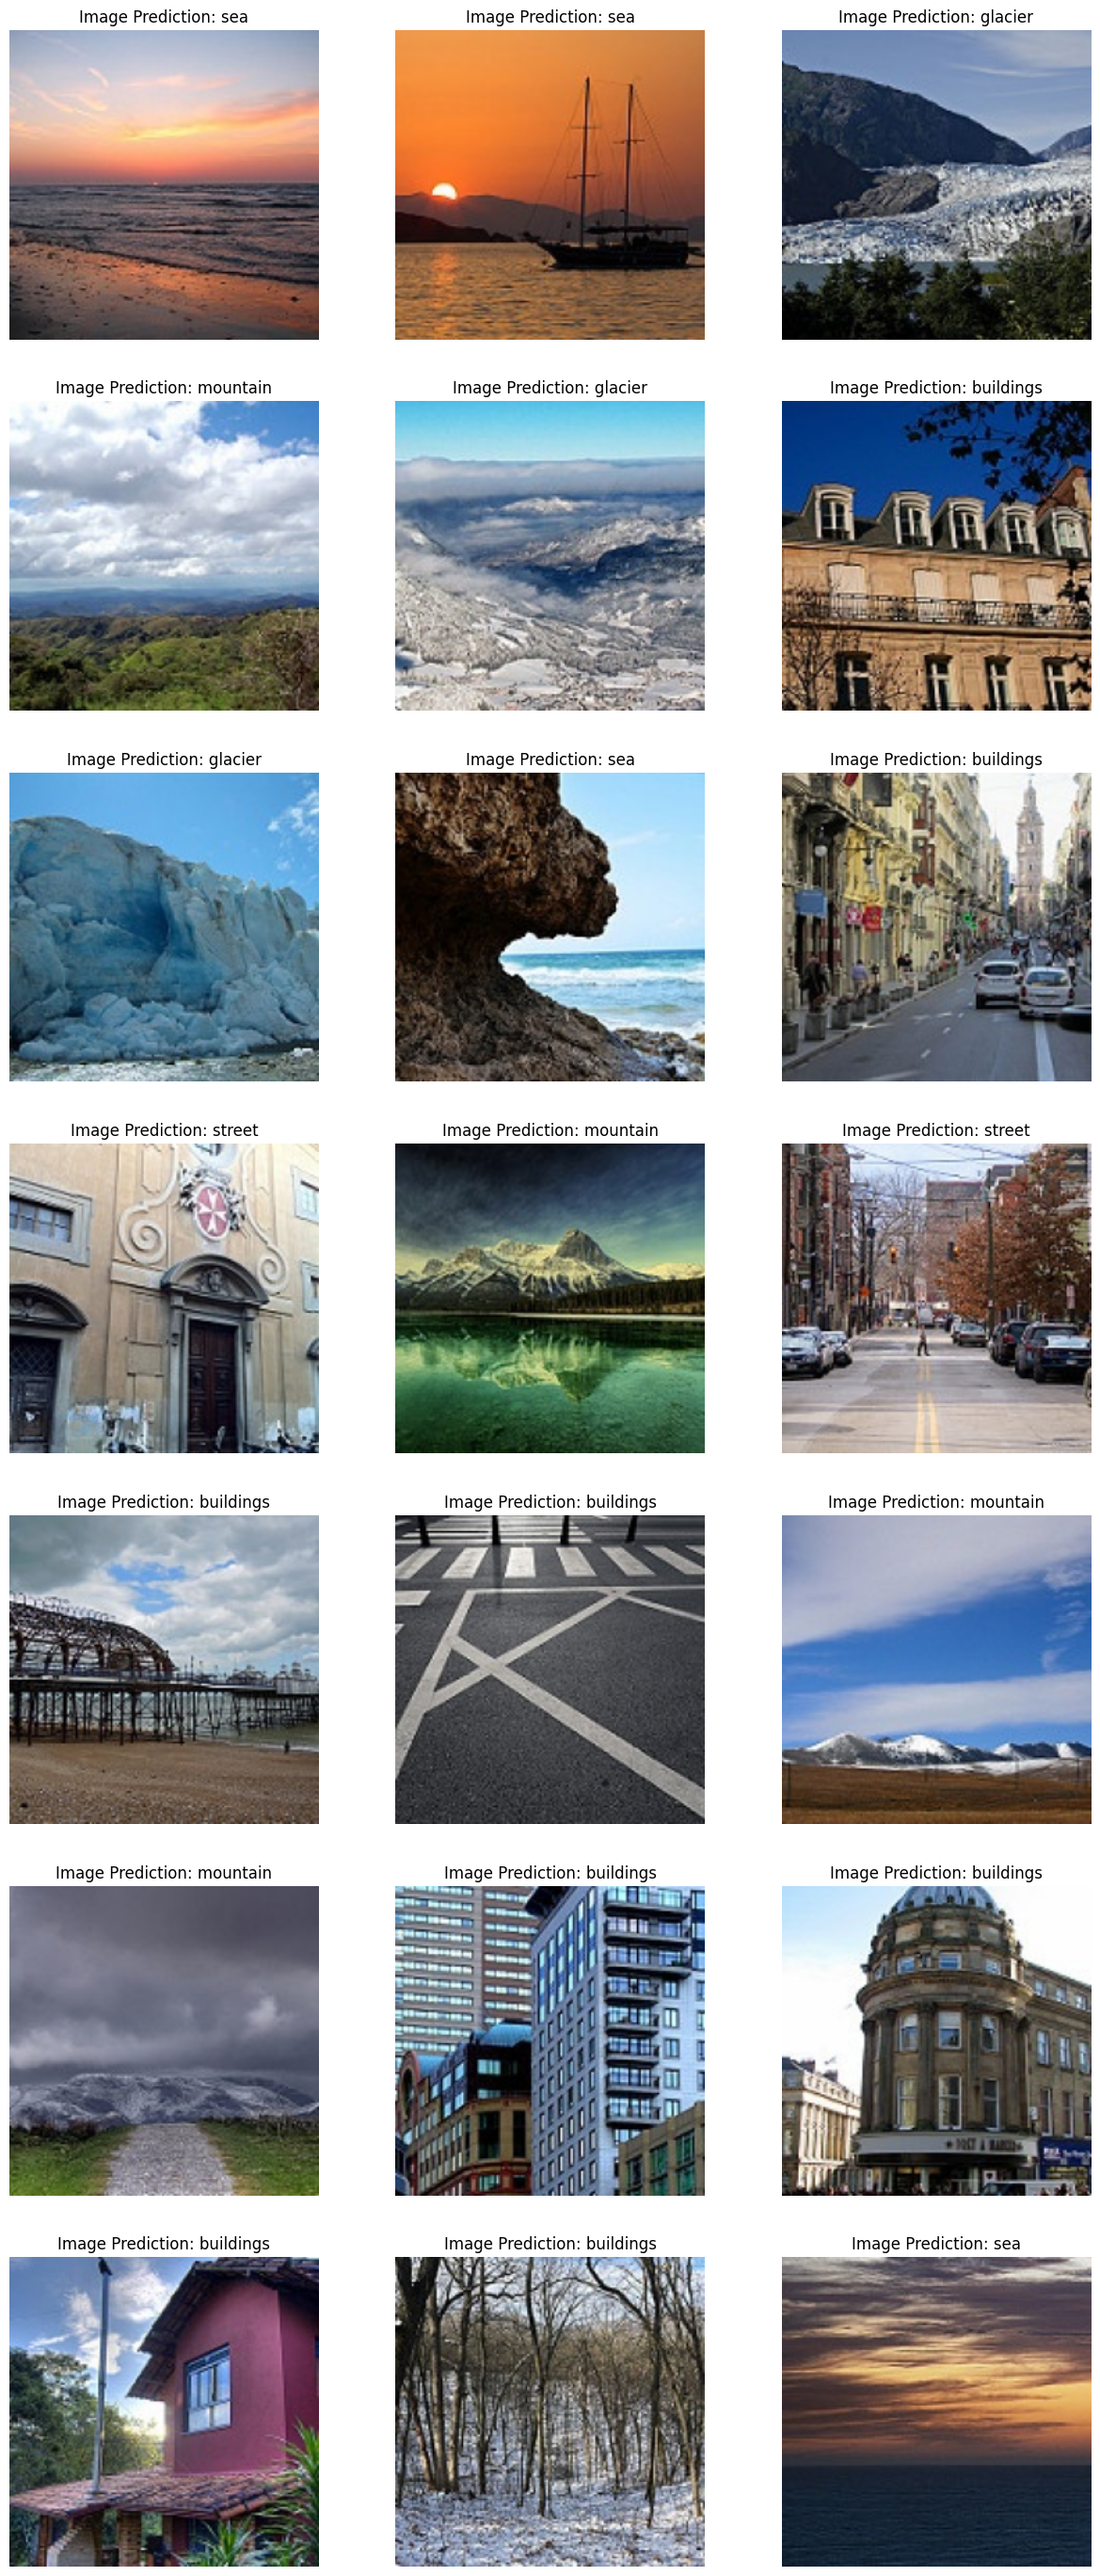

In [28]:
num_images = 21
predict_images(num_images)